# Importing needed libraries

In [8]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from hyperopt import hp, fmin, tpe, Trials
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.datasets import make_regression
import pandas as pd
import numpy as np
import time
import pickle
from hyperopt import fmin, tpe, Trials
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, precision_score, recall_score, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Loading dataset

In [9]:
df = pd.read_csv('harddrive/harddrive.csv')
print(df.shape)
df.head()

(3179295, 95)


,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,...,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
0,2016-01-01,MJ0351YNG9Z0XA,Hitachi HDS5C3030ALA630,1.482490e-311,0,100,0,135.0,108.0,143,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-01-01,Z305B2QN,ST4000DM000,1.976651e-311,0,113,54551400,NaN,NaN,96,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-01-01,MJ0351YNG9Z7LA,Hitachi HDS5C3030ALA630,1.482490e-311,0,100,0,136.0,104.0,124,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-01-01,MJ0351YNGABYAA,Hitachi HDS5C3030ALA630,1.482490e-311,0,100,0,136.0,104.0,137,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-01-01,WD-WMC4N2899475,WDC WD30EFRX,1.482490e-311,0,200,0,NaN,NaN,175,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
df = df.loc[:, ~df.isnull().all()]


# number of hdd
print("number of hdd:", df['serial_number'].value_counts().shape) 

# number of different types of harddrives
print("number of different harddrives", df['model'].value_counts().shape)

failed_hdds = df.loc[df.failure==1]["serial_number"]

print("Number of failed hdd: ", len(failed_hdds))

df = df.loc[df["serial_number"].isin(failed_hdds)]



number of hdd: (65993,)
number of different harddrives (69,)
Number of failed hdd:  215


# Finding the RUL (Remaining Useful Life)

In [11]:
df["end_date"] = df.groupby("serial_number")["date"].transform("max")

df["end_date"] = pd.to_datetime(df["end_date"])
df["date"] = pd.to_datetime(df["date"])


df["date_diff"] = df["end_date"] - df["date"]
df["date_diff"].describe()

count                          5490
mean     49 days 09:18:25.573770492
std      44 days 09:17:21.395230515
min                 0 days 00:00:00
25%                 7 days 00:00:00
50%                21 days 00:00:00
75%                95 days 00:00:00
max               119 days 00:00:00
Name: date_diff, dtype: object

# Check number of null entries

In [12]:
df.isnull().sum()

date                       0
serial_number              0
model                      0
capacity_bytes             0
failure                    0
                        ... 
smart_252_raw           4973
smart_254_normalized    4921
smart_254_raw           4921
end_date                   0
date_diff                  0
Length: 93, dtype: int64

# Getting rid of NaN values

In [13]:
df_notna = df[df.columns[~(df.isna().sum().values/len(df) > 0.05)]]
df_notna.dropna(inplace=True)
df = df_notna.copy()
df.reset_index(inplace=True, drop=True)

/var/folders/45/r14j5zpn55q7sh5r_dqgzfy00000gn/T/ipykernel_7391/1608320578.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna.dropna(inplace=True)


# Check result

In [14]:
df.isnull().sum()

date                    0
serial_number           0
model                   0
capacity_bytes          0
failure                 0
smart_1_normalized      0
smart_1_raw             0
smart_3_normalized      0
smart_3_raw             0
smart_4_normalized      0
smart_4_raw             0
smart_5_normalized      0
smart_5_raw             0
smart_7_normalized      0
smart_7_raw             0
smart_9_normalized      0
smart_9_raw             0
smart_10_normalized     0
smart_10_raw            0
smart_12_normalized     0
smart_12_raw            0
smart_188_raw           0
smart_192_normalized    0
smart_192_raw           0
smart_193_normalized    0
smart_193_raw           0
smart_194_normalized    0
smart_194_raw           0
smart_197_normalized    0
smart_197_raw           0
smart_198_normalized    0
smart_198_raw           0
smart_199_normalized    0
smart_199_raw           0
smart_240_raw           0
smart_241_raw           0
smart_242_raw           0
end_date                0
date_diff   

# Rename columns for readability

In [15]:
df = df.rename(columns={
    "smart_5_normalized": "REAllOCATED_SECTOR_COUNT_N",
    "smart_187_normalized": "REPORTED_UNCORRECTABLE_ERRORS_N",
    "smart_188_normalized": "COMMAND_TIMEOUT_N",
    "smart_197_normalized": "CURRENT_PENDING_SECTOR_COUNT_N",
    "smart_198_normalized": "OFFLINE_UNCORRECTABLE_N",
    "smart_9_normalized": "POWER_ON_HOURS_N",
    "smart_5_raw": "REAllOCATED_SECTOR_COUNT_R",
    "smart_187_raw": "REPORTED_UNCORRECTABLE_ERRORS_R",
    "smart_188_raw": "COMMAND_TIMEOUT_R",
    "smart_197_raw": "CURRENT_PENDING_SECTOR_COUNT_R",
    "smart_198_raw": "OFFLINE_UNCORRECTABLE_R",
    "smart_9_raw": "POWER_ON_HOURS_R",
    "date": "DATE",
    "serial_number": "SERIAL_NUMBER",
    "model": "MODEL",
    "capacity_bytes": "CAPACITY_BYTES",
    "failure": "FAILURE",
    "smart_10_normalized": "Spin_Retry_Count_N",
    "smart_10_raw": "Spin_Retry_Count_R",
    "smart_12_normalized": "Power_Cycle_Count_N",
    "smart_12_raw": "Power_Cycle_Count_R",
    "smart 192_normalized": "Power-Off_Retract_Count_N",
    "smart_192_raw": "Power-Off_Retract_Count_R",
    "smart_240_raw": "Head_Flying_Hours_R",
    "smart_3_normalized": "Spin_Up_Time_N",
    "smart_3_raw": "Spin_Up_Time_R",
    "smart_4_normalized": "Start_Stop_Count_N",
    "smart_4_raw": "Start_Stop_Count_R",
    "smart_7_normalized": "Seek_Error_Rate_N",
    "smart_7_raw": "Seek_Error_Rate_R",
    "smart_241_normalized": "Total_LBAs_Written_N",
    "smart_242_normalized": "Total_LBAs_Read_N",
    "smart_199_normalized": "UDMA_CRC_Error_Count_N",
    "smart_199_raw": "UDMA_CRC_Error_Count_R",
    "smart_9_normalized": "Power_On",
    "smart_9_raw": "Power_On_Hours_R",
    "smart_194_normalized": "Temperature_Celsius_N",
    "smart_194_raw": "Temperature_Celsius_R",
    "smart_241_raw": "Total_LBAs_Written_R",
    "smart_242_raw": "Total_LBAs_Read_R",
    "smart_192_normalized": "Power-Off_Retract_Count_N",
    "smart_193_normalized": "Load_Cycle_Count_N",
    "smart_193_raw": "Load_Cycle_Count_R"
})

# Feature Engineering to create new features

In [16]:
df['POWER_ON_HOURS_UTILIZATION'] = df['Power_On_Hours_R'] / df['Power_On']
df['SPIN_RETRY_TO_POWER_CYCLE_RATIO'] = df['Spin_Retry_Count_R'] / df['Power_Cycle_Count_R']
df['REAllOCATED_SECTOR_ERROR_RATE'] = df['REAllOCATED_SECTOR_COUNT_R'] / df['REAllOCATED_SECTOR_COUNT_N']
df['CURRENT_PENDING_SECTOR_ERROR_RATE'] = df['CURRENT_PENDING_SECTOR_COUNT_R'] / df['CURRENT_PENDING_SECTOR_COUNT_N']
df['TEMPERATURE_DIFFERENCE'] = df['Temperature_Celsius_N'] - df['Temperature_Celsius_R']
df['MOVING_AVERAGE_READ_ERROR_RATE'] = df['REAllOCATED_SECTOR_ERROR_RATE'].rolling(window=30, min_periods=1).mean()
df['REAllOCATED_SECTOR_ERROR_TREND'] = np.where(df['REAllOCATED_SECTOR_COUNT_R'].diff() > 0, 1, -1)
failure_rates = df.groupby('SERIAL_NUMBER')['FAILURE'].mean()
df['FAILURE_PROBABILITY'] = df['SERIAL_NUMBER'].map(failure_rates)

In [18]:
df.columns

Index(['DATE', 'SERIAL_NUMBER', 'MODEL', 'CAPACITY_BYTES', 'FAILURE',
       'smart_1_normalized', 'smart_1_raw', 'Spin_Up_Time_N', 'Spin_Up_Time_R',
       'Start_Stop_Count_N', 'Start_Stop_Count_R',
       'REAllOCATED_SECTOR_COUNT_N', 'REAllOCATED_SECTOR_COUNT_R',
       'Seek_Error_Rate_N', 'Seek_Error_Rate_R', 'Power_On',
       'Power_On_Hours_R', 'Spin_Retry_Count_N', 'Spin_Retry_Count_R',
       'Power_Cycle_Count_N', 'Power_Cycle_Count_R', 'COMMAND_TIMEOUT_R',
       'Power-Off_Retract_Count_N', 'Power-Off_Retract_Count_R',
       'Load_Cycle_Count_N', 'Load_Cycle_Count_R', 'Temperature_Celsius_N',
       'Temperature_Celsius_R', 'CURRENT_PENDING_SECTOR_COUNT_N',
       'CURRENT_PENDING_SECTOR_COUNT_R', 'OFFLINE_UNCORRECTABLE_N',
       'OFFLINE_UNCORRECTABLE_R', 'UDMA_CRC_Error_Count_N',
       'UDMA_CRC_Error_Count_R', 'Head_Flying_Hours_R', 'Total_LBAs_Written_R',
       'Total_LBAs_Read_R', 'end_date', 'date_diff',
       'POWER_ON_HOURS_UTILIZATION', 'SPIN_RETRY_TO_POWER_

In [19]:
# List of raw columns to drop
raw_columns_to_drop = [
    "REAllOCATED_SECTOR_COUNT_R",
    "COMMAND_TIMEOUT_R",
    "CURRENT_PENDING_SECTOR_COUNT_R",
    "OFFLINE_UNCORRECTABLE_R",
    "Power_On_Hours_R",
    "Spin_Retry_Count_R",
    "Power_Cycle_Count_R",
    "Power-Off_Retract_Count_R",
    "Head_Flying_Hours_R",
    "Spin_Up_Time_R",
    "Start_Stop_Count_R",
    "Seek_Error_Rate_R",
    "Total_LBAs_Written_R",
    "Total_LBAs_Read_R",
    "UDMA_CRC_Error_Count_R",
    "Load_Cycle_Count_R"
]

# Dropping the raw columns
df.drop(columns=raw_columns_to_drop, inplace=True)

# Dropping unwanted columns, Splitting Data and Training Model

In [20]:
df = df.drop(['DATE', 'SERIAL_NUMBER', 'MODEL','end_date'], axis=1)
df.head()

,CAPACITY_BYTES,FAILURE,smart_1_normalized,smart_1_raw,Spin_Up_Time_N,Start_Stop_Count_N,REAllOCATED_SECTOR_COUNT_N,Seek_Error_Rate_N,Power_On,Spin_Retry_Count_N,...,UDMA_CRC_Error_Count_N,date_diff,POWER_ON_HOURS_UTILIZATION,SPIN_RETRY_TO_POWER_CYCLE_RATIO,REAllOCATED_SECTOR_ERROR_RATE,CURRENT_PENDING_SECTOR_ERROR_RATE,TEMPERATURE_DIFFERENCE,MOVING_AVERAGE_READ_ERROR_RATE,REAllOCATED_SECTOR_ERROR_TREND,FAILURE_PROBABILITY
0,1.976651e-311,0,120,240872800,91,100,100,84,81,100,...,200,16 days,205.975309,0.0,0.0,0.00,0.0,0.0,-1,0.055556
1,1.976651e-311,0,118,190147064,91,100,100,87,77,100,...,200,108 days,263.194805,0.0,0.0,0.00,0.0,0.0,-1,0.024390
2,1.976651e-311,0,115,85258376,92,100,100,87,77,100,...,200,99 days,263.272727,0.0,0.0,0.00,0.0,0.0,-1,0.031250
3,1.976651e-311,0,116,101976792,91,100,100,84,81,100,...,200,9 days,208.876543,0.0,0.0,0.08,0.0,0.0,-1,0.090909
4,2.964974e-311,0,116,101694695,88,100,100,90,86,100,...,200,95 days,142.883721,0.0,0.0,0.00,0.0,0.0,-1,0.035714


In [21]:
df.columns

Index(['CAPACITY_BYTES', 'FAILURE', 'smart_1_normalized', 'smart_1_raw',
       'Spin_Up_Time_N', 'Start_Stop_Count_N', 'REAllOCATED_SECTOR_COUNT_N',
       'Seek_Error_Rate_N', 'Power_On', 'Spin_Retry_Count_N',
       'Power_Cycle_Count_N', 'Power-Off_Retract_Count_N',
       'Load_Cycle_Count_N', 'Temperature_Celsius_N', 'Temperature_Celsius_R',
       'CURRENT_PENDING_SECTOR_COUNT_N', 'OFFLINE_UNCORRECTABLE_N',
       'UDMA_CRC_Error_Count_N', 'date_diff', 'POWER_ON_HOURS_UTILIZATION',
       'SPIN_RETRY_TO_POWER_CYCLE_RATIO', 'REAllOCATED_SECTOR_ERROR_RATE',
       'CURRENT_PENDING_SECTOR_ERROR_RATE', 'TEMPERATURE_DIFFERENCE',
       'MOVING_AVERAGE_READ_ERROR_RATE', 'REAllOCATED_SECTOR_ERROR_TREND',
       'FAILURE_PROBABILITY'],
      dtype='object')

In [22]:
Y = df["date_diff"].dt.days
X = df.drop(["date_diff"],axis=1)

In [23]:
from sklearn.model_selection import train_test_split

# Assuming you have your features in X and target variable in y
# Replace this with your actual data

# Perform train-test split (adjust test_size and random_state as needed)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Print the shapes of the resulting splits
print("Shapes - X_train:", X_train.shape, "X_test:", X_test.shape, "y_train:", y_train.shape, "y_test:", y_test.shape)


Shapes - X_train: (4272, 26) X_test: (1068, 26) y_train: (4272,) y_test: (1068,)


In [24]:
classifiers = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=1.0),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "Support Vector Machine": SVR(),
    "K-Nearest Neighbors": KNeighborsRegressor(),
    "Neural Network": MLPRegressor(),
    "Gaussian Process": GaussianProcessRegressor(),
    "XGBoost": XGBRegressor(),
    "LightGBM": LGBMRegressor(),
    "CatBoost": CatBoostRegressor()
}

# CHECK IMPORTANCE OF FEATURES

In [25]:

from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
model.fit(X, Y)
feature_importances = model.feature_importances_

map_ = {}

for i, a in enumerate(X):
    map_[a] = feature_importances[i]
    
sorted_features = sorted(map_.items(), key=lambda x: x[1], reverse=True)

# Iterate through sorted features and format the output
formatted_features = [(column_name, importance) for column_name, importance in sorted_features]

# Print the formatted features
for column_name, importance in formatted_features:
    print(f"Column Name: {column_name}, Importance: {importance}")

Column Name: FAILURE_PROBABILITY, Importance: 0.2408339562054203
Column Name: MOVING_AVERAGE_READ_ERROR_RATE, Importance: 0.2278743750209205
Column Name: POWER_ON_HOURS_UTILIZATION, Importance: 0.1421986459693355
Column Name: Power_On, Importance: 0.07243445008062925
Column Name: Load_Cycle_Count_N, Importance: 0.05786784221747106
Column Name: CURRENT_PENDING_SECTOR_ERROR_RATE, Importance: 0.05003559851410758
Column Name: Spin_Up_Time_N, Importance: 0.039801740315664094
Column Name: Temperature_Celsius_R, Importance: 0.03814666321668761
Column Name: Seek_Error_Rate_N, Importance: 0.025890124162210152
Column Name: Temperature_Celsius_N, Importance: 0.02478556659369702
Column Name: FAILURE, Importance: 0.02223953025394096
Column Name: REAllOCATED_SECTOR_ERROR_RATE, Importance: 0.01757397217053232
Column Name: TEMPERATURE_DIFFERENCE, Importance: 0.014170655332661998
Column Name: REAllOCATED_SECTOR_COUNT_N, Importance: 0.008756351747265915
Column Name: smart_1_raw, Importance: 0.0053215261

# TESTING A NUMBER OF REGRESSORS TO CHOOSE THE BEST MODEL

In [26]:
# Create an empty DataFrame to store the results
columns = ['Model', 'Run Time (minutes)', 'MAE', 'MSE', 'RMSE', 'R2']
df_models = pd.DataFrame(columns=columns)

# Loop through your regression models
for key, clf in classifiers.items():
    # STARTING TIME
    start_time = time.time()
    # TRAIN CLASSIFIER ON TRAINING DATA
    clf.fit(X_train, y_train)
    
    #SAVE THE TRAINED MODEL
    classifiers[key] = clf
    
    # MAKE PREDICTIONS USING CURRENT CLASSIFIER
    predictions = clf.predict(X_test)
    
    # CALCULATE REGRESSION METRICS
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = mean_squared_error(y_test, predictions, squared=False)  # Calculate RMSE
    r2 = r2_score(y_test, predictions)

    row = {'Model': key,
           'Run Time (minutes)': round((time.time() - start_time) / 60, 2),
           'MAE': mae,
           'MSE': mse,
           'RMSE': rmse,
           'R2': r2
           }

    df_models = pd.concat([df_models, pd.DataFrame([row])], ignore_index=True)

# Sort the DataFrame by R-squared (R2) in descending order
df_models = df_models.sort_values(by='R2', ascending=False)

# PRINT THE MODELS WITH REGRESSION METRICS [SORTED]
print(df_models)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/var/folders/45/r14j5zpn55q7sh5r_dqgzfy00000gn/T/ipykernel_7391/2199124386.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_models = pd.concat([df_models, pd.DataFrame([row])], ignore_index=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=3.33011e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos",

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001171 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1341
[LightGBM] [Info] Number of data points in the train set: 4272, number of used features: 22
[LightGBM] [Info] Start training from score 48.681414


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Learning rate set to 0.051501
0:	learn: 43.4337404	total: 58.5ms	remaining: 58.5s
1:	learn: 42.7669667	total: 59.4ms	remaining: 29.6s
2:	learn: 42.0786323	total: 60.2ms	remaining: 20s
3:	learn: 41.4160073	total: 61ms	remaining: 15.2s
4:	learn: 40.8741187	total: 61.9ms	remaining: 12.3s
5:	learn: 40.3762567	total: 62.7ms	remaining: 10.4s
6:	learn: 39.8672303	total: 63.6ms	remaining: 9.02s
7:	learn: 39.3072613	total: 64.3ms	remaining: 7.98s
8:	learn: 38.7790827	total: 65.2ms	remaining: 7.18s
9:	learn: 38.3133239	total: 66ms	remaining: 6.53s
10:	learn: 37.8213594	total: 66.8ms	remaining: 6s
11:	learn: 37.4962046	total: 67.5ms	remaining: 5.56s
12:	learn: 37.1159943	total: 68.3ms	remaining: 5.19s
13:	learn: 36.6418878	total: 69.1ms	remaining: 4.86s
14:	learn: 36.3460688	total: 69.8ms	remaining: 4.58s
15:	learn: 36.0346540	total: 70.6ms	remaining: 4.34s
16:	learn: 35.8183933	total: 71.6ms	remaining: 4.14s
17:	learn: 35.4826236	total: 72.3ms	remaining: 3.95s
18:	learn: 35.1802838	total: 73.2ms

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [27]:
df_models

,Model,Run Time (minutes),MAE,MSE,RMSE,R2
10,XGBoost,0.00,4.449981,5.280798e+01,7.266910,0.973559
4,Random Forest,0.03,3.209466,5.386262e+01,7.339116,0.973031
12,CatBoost,0.02,5.941600,7.569941e+01,8.700541,0.962097
11,LightGBM,0.01,5.830738,8.803156e+01,9.382514,0.955922
3,Decision Tree,0.00,3.054307,1.304625e+02,11.422020,0.934677
5,Gradient Boosting,0.01,17.308644,4.917696e+02,22.175879,0.753770
0,Linear Regression,0.00,39.397513,1.720610e+03,41.480235,0.138488
1,Ridge,0.00,39.494062,1.728642e+03,41.576938,0.134466
7,K-Nearest Neighbors,0.01,34.914419,1.827576e+03,42.750157,0.084930
2,Lasso,0.01,41.091192,1.837939e+03,42.871195,0.079741


# RESULT - XGBOOST & RANDOM FOREST Perform Best

## Further, we test Random forest with and without hyperparameter tuning

# Random Forest Without Hyper Parameter Tuning

Random Forest MSE: 37.1659813670412
Random Forest R^2 score: 0.9813909299534799


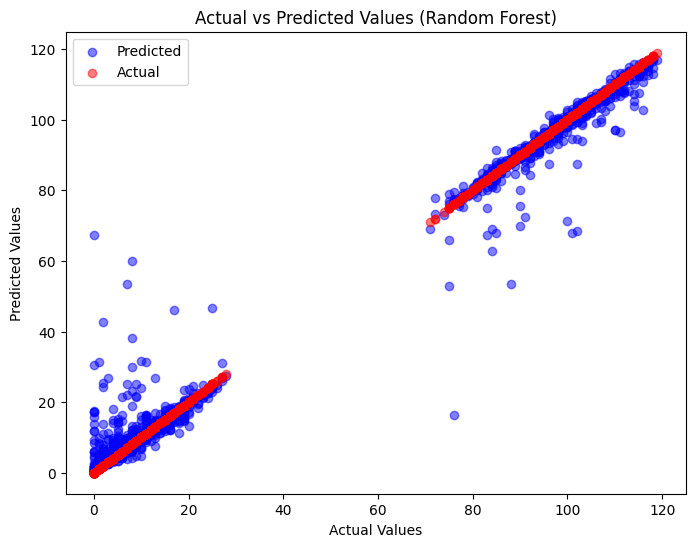

In [122]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Creating Random Forest Regressor
RF_model = RandomForestRegressor(random_state=1)
RF_model.fit(X_train, y_train)

# Predicting on test data
y_pred_RF = RF_model.predict(X_test)

# Calculating Mean Squared Error
mse_RF = mean_squared_error(y_test, y_pred_RF)
print("Random Forest MSE:", mse_RF)

# Calculating R^2 score
score_RF = RF_model.score(X_test, y_test)
print("Random Forest R^2 score:", score_RF)

# Visualizing Actual vs Predicted values with different colors
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_RF, alpha=0.5, label='Predicted', color='blue')
plt.scatter(y_test, y_test, alpha=0.5, label='Actual', color='red')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (Random Forest)')
plt.legend()
plt.show()

# Decision Tree Without HyperParameter Tuning

Decision Tree MSE: 65.98408239700375
Decision Tree R^2 score: 0.9669616577817558


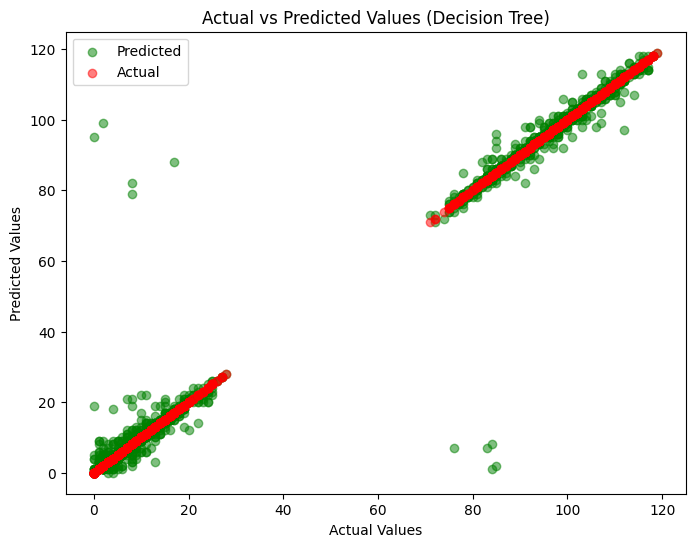

In [123]:
from sklearn.tree import DecisionTreeRegressor

# Creating Decision Tree Regressor
DT_model = DecisionTreeRegressor(random_state=1)
DT_model.fit(X_train, y_train)

# Predicting on test data
y_pred_DT = DT_model.predict(X_test)

# Calculating Mean Squared Error
mse_DT = mean_squared_error(y_test, y_pred_DT)
print("Decision Tree MSE:", mse_DT)

# Calculating R^2 score
score_DT = DT_model.score(X_test, y_test)
print("Decision Tree R^2 score:", score_DT)

# Visualizing Actual vs Predicted values with different colors
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_DT, alpha=0.5, label='Predicted', color='green')
plt.scatter(y_test, y_test, alpha=0.5, label='Actual', color='red')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (Decision Tree)')
plt.legend()
plt.show()


# Random Forest Parameter Tuning With Hyperopt

In [129]:
seed=2
def objective(params):
    est=int(params['n_estimators'])
    md=int(params['max_depth'])
    msl=int(params['min_samples_leaf'])
    mss=int(params['min_samples_split'])
    model=RandomForestRegressor(n_estimators=est,max_depth=md,min_samples_leaf=msl,min_samples_split=mss)
    model.fit(X_train,y_train)
    pred=model.predict(X_test)
    score=mean_squared_error(y_test,pred)
    return score

def optimize(trial):
    params={'n_estimators':hp.uniform('n_estimators',10,100),
           'max_depth':hp.uniform('max_depth',5,20),
           'min_samples_leaf':hp.uniform('min_samples_leaf',1,5),
           'min_samples_split':hp.uniform('min_samples_split',2,6)}
    best=fmin(fn=objective,space=params,algo=tpe.suggest,trials=trial,max_evals=150,rstate=np.random.default_rng(seed=2))
    return best

trial=Trials()
best=optimize(trial)

100%|██████████| 150/150 [02:34<00:00,  1.03s/trial, best loss: 41.93585441876957]


In [130]:
print(best)

for t in trial.trials[:2]:
    print (t)

{'max_depth': 19.283821736528648, 'min_samples_leaf': 1.9269842624531341, 'min_samples_split': 5.168390189034901, 'n_estimators': 32.40757028435153}
{'state': 2, 'tid': 0, 'spec': None, 'result': {'loss': 75.26036892335165, 'status': 'ok'}, 'misc': {'tid': 0, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'max_depth': [0], 'min_samples_leaf': [0], 'min_samples_split': [0], 'n_estimators': [0]}, 'vals': {'max_depth': [17.06974354546972], 'min_samples_leaf': [2.3918730381022115], 'min_samples_split': [2.9289857075688754], 'n_estimators': [65.86711620344198]}}, 'exp_key': None, 'owner': None, 'version': 0, 'book_time': datetime.datetime(2024, 4, 3, 14, 17, 34, 39000), 'refresh_time': datetime.datetime(2024, 4, 3, 14, 17, 35, 261000)}
{'state': 2, 'tid': 1, 'spec': None, 'result': {'loss': 289.16268231281845, 'status': 'ok'}, 'misc': {'tid': 1, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'max_depth': [1], 'min_samples_leaf': [1], '

In [131]:
TID=[t['tid'] for t in trial.trials]
Loss=[t['result']['loss'] for t in trial.trials]
maxd=[t['misc']['vals']['max_depth'][0] for t in trial.trials]
nest=[t['misc']['vals']['n_estimators'][0] for t in trial.trials]
min_ss=[t['misc']['vals']['min_samples_split'][0] for t in trial.trials]
min_sl=[t['misc']['vals']['min_samples_leaf'][0] for t in trial.trials]

hyperopt_rfr=pd.DataFrame({'tid':TID,'loss':Loss,
                          'max_depth':maxd,'n_estimators':nest,
                          'min_samples_split':min_ss, 'min_samples_leaf':min_sl})

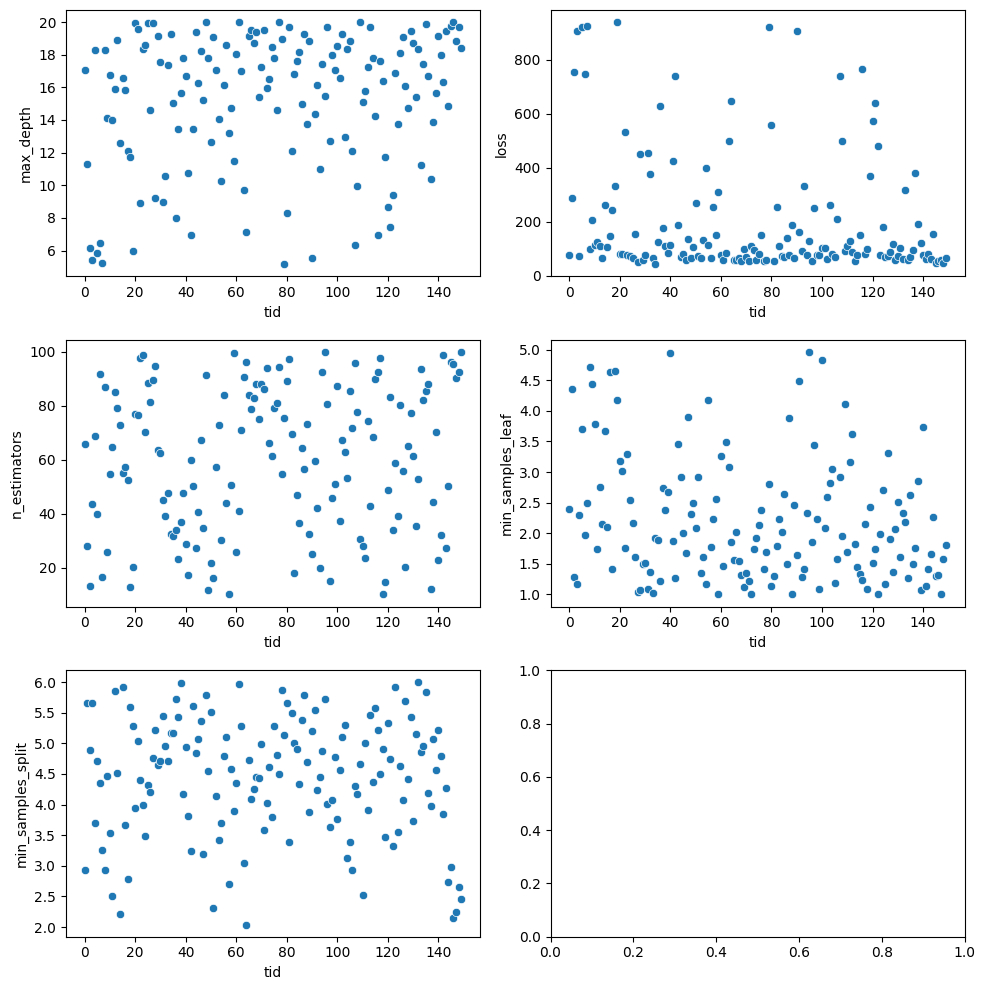

In [132]:
plt.subplots(3,2,figsize=(10,10))
plt.subplot(3,2,1)
sns.scatterplot(x='tid',y='max_depth',data=hyperopt_rfr)
plt.subplot(3,2,2)
sns.scatterplot(x='tid',y='loss',data=hyperopt_rfr)
plt.subplot(3,2,3)
sns.scatterplot(x='tid',y='n_estimators',data=hyperopt_rfr)
plt.subplot(3,2,4)
sns.scatterplot(x='tid',y='min_samples_leaf',data=hyperopt_rfr)
plt.subplot(3,2,5)
sns.scatterplot(x='tid',y='min_samples_split',data=hyperopt_rfr)

plt.tight_layout()

In [133]:
best_params = {
    'n_estimators': int(best['n_estimators']),
    'max_depth': int(best['max_depth']),
    'min_samples_leaf': int(best['min_samples_leaf']),
    'min_samples_split': int(best['min_samples_split']),
    'random_state': 2  # Assuming you want to set the random state
}

rfr_opt = RandomForestRegressor(**best_params)
rfr_opt.fit(X_train,y_train)
pred_rfr_opt=rfr_opt.predict(X_test)
score_rfr_opt=mean_squared_error(y_test,pred_rfr_opt)
score = rfr_opt.score(X_test, y_test)
print("MSE Random Forest After HyperParameter Tuning With Hyperopt: ", score_rfr_opt)
print("R^2 Score Random Forest After Hyperparameter Tuning With Hyperopt: ", score)

MSE Random Forest After HyperParameter Tuning With Hyperopt:  56.23503714529067
R^2 Score Random Forest After Hyperparameter Tuning With Hyperopt:  0.9718430213110586


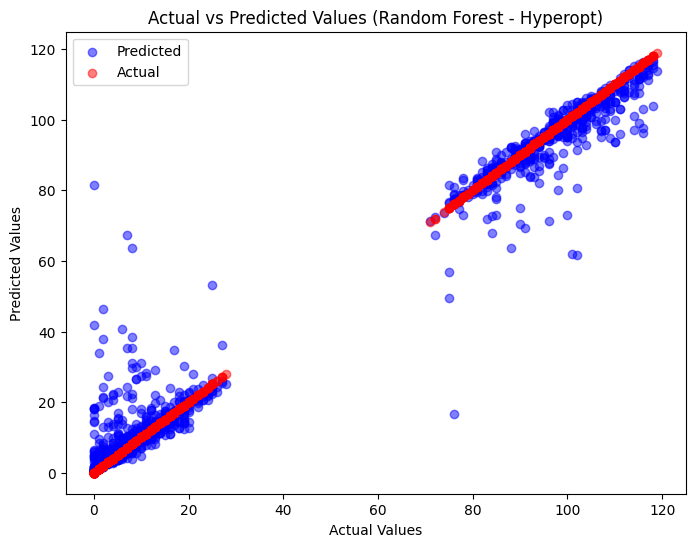

In [134]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, pred_rfr_opt, alpha=0.5, label='Predicted', color='blue')
plt.scatter(y_test, y_test, alpha=0.5, label='Actual', color='red')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (Random Forest - Hyperopt)')
plt.legend()
plt.show()